Using 851 overlapping years for GISS-E2-1-G
[saved] /ocean/projects/ees250004p/ezhu3/data/GISS-E2-1-G/ML-data/GISS-E2-1-G_piControl_TOA_annual.nc
[saved] /ocean/projects/ees250004p/ezhu3/data/GISS-E2-1-G/ML-data/GISS-E2-1-G_piControl_toa_gm_GM_timeseries.nc
[saved] /ocean/projects/ees250004p/ezhu3/data/GISS-E2-1-G/ML-data/GISS-E2-1-G_piControl_toa_gm_anom_GM_timeseries.nc
[saved] /ocean/projects/ees250004p/ezhu3/data/GISS-E2-1-G/ML-data/GISS-E2-1-G_abrupt-4xCO2_TOA_annual.nc
[GISS-E2-1-G] Computed ERF: 7.88 W/m²
[saved] /ocean/projects/ees250004p/ezhu3/data/GISS-E2-1-G/ML-data/GISS-E2-1-G_abrupt-4xCO2-150_toa_gm_GM_timeseries.nc
[saved] /ocean/projects/ees250004p/ezhu3/data/GISS-E2-1-G/ML-data/GISS-E2-1-G_abrupt-4xCO2-150_toa_gm_anom_GM_timeseries.nc
[saved] /ocean/projects/ees250004p/ezhu3/data/GISS-E2-1-G/ML-data/GISS-E2-1-G_abrupt-4xCO2-150_ts_gm_GM_timeseries.nc
[saved] /ocean/projects/ees250004p/ezhu3/data/GISS-E2-1-G/ML-data/GISS-E2-1-G_abrupt-4xCO2-150_ts_gm_anom_GM_timeseries.n

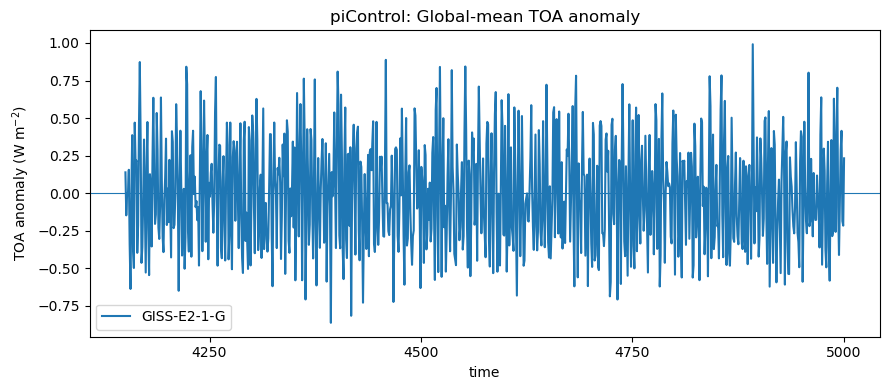

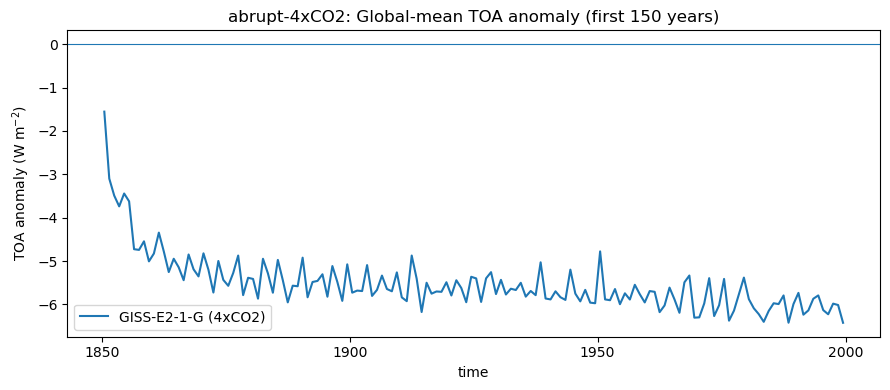

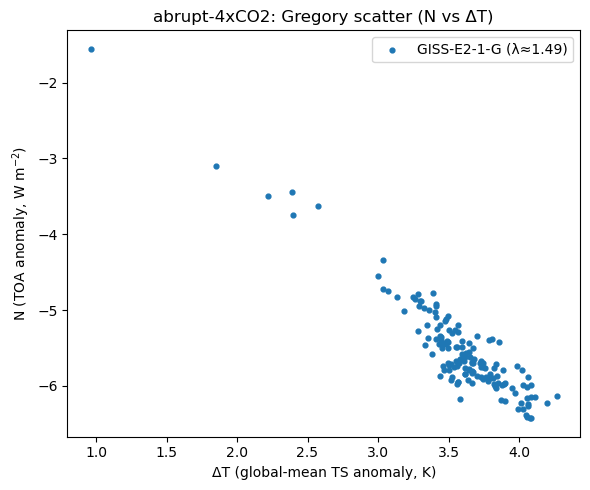

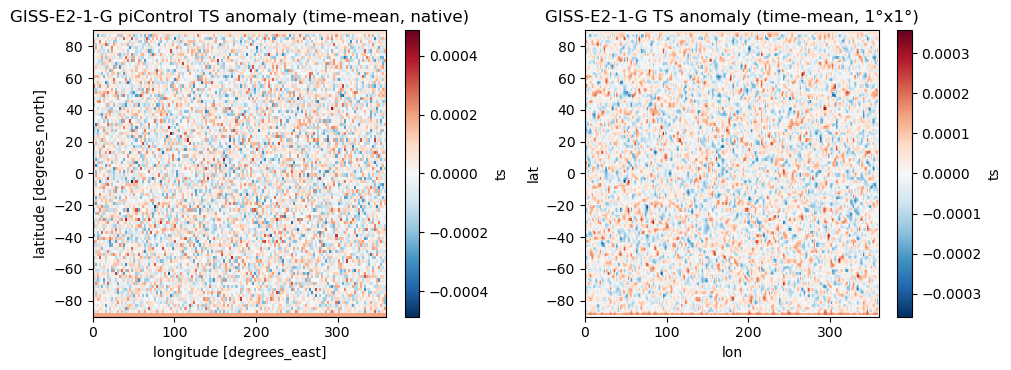

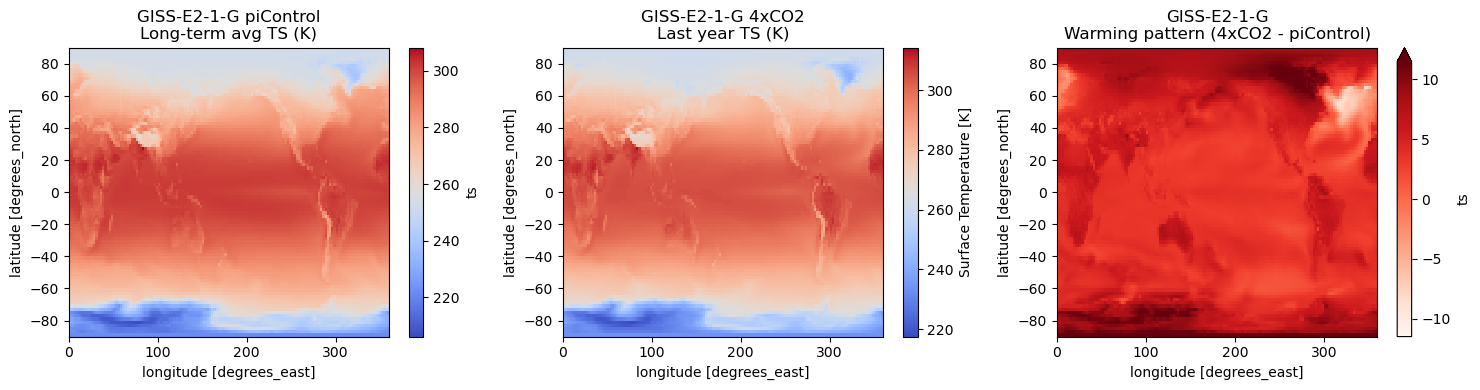

GISS-E2-1-G: lambda ≈ 1.49 W m^-2 K^-1


In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os

# =====================
# output setting
# =====================
OUT_DIR = "/ocean/projects/ees250004p/ezhu3/data/GISS-E2-1-G/ML-data/"
os.makedirs(OUT_DIR, exist_ok=True)

def save_toa_netcdf(toa_da: xr.DataArray, model: str, experiment: str):
    """
    Save gridded annual TOA (rsdt - rsut - rlut) as a NetCDF file.
    Keeps original time/lat/lon coords. Uses compression.
    """
    # Ensure coords are clean and ordered
    toa_da = toa_da.sortby(["time"] + [c for c in ["lat","lon"] if c in toa_da.coords])

    # Build dataset with attrs
    ds_out = toa_da.to_dataset(name="toa")
    # Variable attrs
    ds_out["toa"].attrs.update({
        "long_name": "Top-of-Atmosphere Net Radiation",
        "standard_name": "toa_net_downward_radiative_flux",
        "units": "W m-2",
        "cell_methods": "time: mean (annual)",
        "note": "Computed as rsdt - rsut - rlut from provided annual means.",
        "source_model": model,
        "experiment_id": experiment,
    })
    # Global attrs
    ds_out.attrs.update({
        "title": f"{model} {experiment} annual TOA net radiation",
        "history": f"Created by verify_cmip6.py; computed as rsdt - rsut - rlut",
        "Conventions": "CF-1.8",
    })

    # Compression encodings
    enc = {var: {"zlib": True, "complevel": 4, "dtype": "float32"}
           for var in ds_out.data_vars}
    # Keep coords in native dtype (don't force float32 for time/lat/lon)
    for coord in ds_out.coords:
        enc[coord] = {}

    # File name
    fn = f"{model}_{experiment}_TOA_annual.nc"
    out_path = os.path.join(OUT_DIR, fn)

    ds_out.to_netcdf(out_path, format="NETCDF4", encoding=enc)
    print(f"[saved] {out_path}")

def save_gm_series(da, name, model, experiment, units):
    ds = xr.Dataset({name: da})
    ds[name].attrs.update({
        "units": units,
        "cell_methods": "area: mean (weighted by cos(lat)); time: mean (annual)",
    })
    ds.attrs.update({
        "title": f"{model} {experiment} global-mean {name}",
        "history": "Created by verify_cmip6.py",
        "Conventions": "CF-1.8",
    })
    enc = {name: {"zlib": True, "complevel": 4, "dtype": "float32"}}
    fn = f"{model}_{experiment}_{name}_GM_timeseries.nc"
    ds.to_netcdf(os.path.join(OUT_DIR, fn), encoding=enc)
    print(f"[saved] {os.path.join(OUT_DIR, fn)}")

# ---- (OPTIONAL) 1° regridding via xESMF ----
try:
    import xesmf as xe
    HAVE_XESMF = True
except Exception:
    HAVE_XESMF = False
    print("Note: xESMF not found; the 1° regridded map will be skipped. `pip/conda install xesmf` to enable.")

# =======================
# USER: FILL THESE PATHS
# =======================
# Provide *ANNUAL* files for each variable & experiment (same ensemble, same grid).
# Add/duplicate blocks for more models (e.g., "NorESM2-LM", "EC-Earth3", etc.)
MODEL_CONFIG = {
    "GISS-E2-1-G": {
        "pi": {
            "rsdt": "/ocean/projects/ees250004p/ezhu3/data/GISS-E2-1-G/control/rsdt/GISS-E2-1-G_piControl_rsdt_annual.nc",  # e.g., "/path/to/IPSL_piControl_rsdt_annual.nc"
            "rsut": "/ocean/projects/ees250004p/ezhu3/data/GISS-E2-1-G/control/rsut/GISS-E2-1-G_piControl_rsut_annual.nc",
            "rlut":"/ocean/projects/ees250004p/ezhu3/data/GISS-E2-1-G/control/rlut/GISS-E2-1-G_piControl_rlut_annual.nc",
            "ts":"/ocean/projects/ees250004p/ezhu3/data/GISS-E2-1-G/control/ts/GISS-E2-1-G_piControl_ts_annual.nc"
        },
        "abrupt4x": {
            "rsdt": "/ocean/projects/ees250004p/ezhu3/data/GISS-E2-1-G/test/rsdt/GISS-E2-1-G_4xCO2_rsdt_annual.nc",  # e.g., "/path/to/IPSL_4xCO2_rsdt_annual.nc"
            "rsut": "/ocean/projects/ees250004p/ezhu3/data/GISS-E2-1-G/test/rsut/GISS-E2-1-G_4xCO2_rsut_annual.nc",
            "rlut": "/ocean/projects/ees250004p/ezhu3/data/GISS-E2-1-G/test/rlut/GISS-E2-1-G_4xCO2_rlut_annual.nc",
            "ts": "/ocean/projects/ees250004p/ezhu3/data/GISS-E2-1-G/test/ts/GISS-E2-1-G_4xCO2_ts_annual.nc"
        }
    },
}

#Save this output to a .nc file = same as our future target

# Which model’s TS anomaly map to show in (4)
MAP_MODEL_NAME = "GISS-E2-1-G"  # change to the model you want (e.g., "CESM2")
LIMIT_4X_YEARS = 150      # typical window for Gregory; set None to use all available

# =======================
# helpers
# =======================
def pick_var(ds, preferred):
    """Return DataArray for `preferred` if present; else the first data_var."""
    if preferred in ds.data_vars:
        return ds[preferred]
    for v in ds.data_vars:
        return ds[v]
    raise ValueError("No data variables found.")

def standardize_lonlat(ds):
    """Rename common lon/lat names to lon/lat and ensure dimensions exist."""
    rename = {}
    for old, new in [("longitude", "lon"), ("latitude", "lat"),
                     ("nav_lon", "lon"), ("nav_lat", "lat")]:
        if old in ds.coords:
            rename[old] = new
        if old in ds.dims:
            rename[old] = new
    ds = ds.rename(rename)
    # ensure increasing lon in [0, 360)
    if "lon" in ds.coords:
        lon = ds["lon"].values
        if np.min(lon) < 0:
            ds = ds.assign_coords(lon=((lon + 360) % 360))
        ds = ds.sortby("lon")
    return ds

def area_weights(da):
    """cos(lat) weights for area-weighted means on regular lon-lat."""
    if "lat" not in da.coords or "lon" not in da.coords:
        raise ValueError("lat/lon coordinates required for area weights.")
    w = np.cos(np.deg2rad(da["lat"]))
    # xarray broadcasts along lon automatically
    return w

def gm(da):
    """Area-weighted global mean."""
    w = area_weights(da)
    return da.weighted(w).mean(dim=("lat", "lon"))

def open_annual(path, varname_guess):
    ds = xr.open_dataset(path)
    ds = standardize_lonlat(ds)
    da = pick_var(ds, varname_guess)
    # enforce time as the sample dimension
    if "time" not in da.dims:
        raise ValueError(f"'time' dimension not found in {path}")
    return da

def compute_toa(rsdt, rsut, rlut):
    """TOA = rsdt - rsut - rlut (all are annual fields)."""
    # align (time, lat, lon)
    rsdt, rsut, rlut = xr.align(rsdt, rsut, rlut, join="inner")
    toa = rsdt - rsut - rlut
    toa.name = "toa"
    return toa

def first_n_years(da, n=None):
    if n is None:
        return da
    n = min(n, da.sizes["time"])
    return da.isel(time=slice(0, n))

def to_year_coord(da):
    """Add 'year' coordinate for nicer plotting if missing."""
    if "year" not in da.coords:
        # try to infer from CF time coordinate if present
        try:
            yr = xr.decode_cf(da.to_dataset(name="tmp"))["tmp"].time.dt.year
            return da.assign_coords(year=yr)
        except Exception:
            # fallback: 0..N-1
            return da.assign_coords(year=("time", np.arange(da.sizes["time"])))
    return da

# =======================
# load + compute
# =======================
models_available = []
pi_toa_gm_anom = {}   # model -> DataArray (time)
fx_toa_gm_anom = {}   # model -> DataArray (time)
lambda_vals = {}      # model -> float
gregory_points = {}   # model -> (dT, N)

for model, paths in MODEL_CONFIG.items():
    try:
        # ---- piControl ----
        pi_rsdt = open_annual(paths["pi"]["rsdt"], "rsdt")
        pi_rsut = open_annual(paths["pi"]["rsut"], "rsut")
        pi_rlut = open_annual(paths["pi"]["rlut"], "rlut")
        pi_ts   = open_annual(paths["pi"]["ts"],   "ts")

        toa_pi  = compute_toa(pi_rsdt, pi_rsut, pi_rlut)
        gm_pi   = gm(toa_pi)
        gm_pi_anom = gm_pi - gm_pi.mean("time")
        
        # Compute TS anomalies (spatial fields) 
        ts_pi_anom = pi_ts - pi_ts.mean("time")  # piControl TS anomalies (spatial)

        # =====================
        # ALIGN DATA TO OVERLAPPING PERIOD (800 years)
        # =====================
        overlap_years = min(ts_pi_anom.shape[0], gm_pi_anom.shape[0])
        print(f"Using {overlap_years} overlapping years for {model}")

        # Truncate ALL related variables to same length
        pi_ts = pi_ts[:overlap_years]
        ts_pi_anom = ts_pi_anom[:overlap_years] 
        toa_pi = toa_pi[:overlap_years]
        gm_pi = gm_pi[:overlap_years]
        gm_pi_anom = gm_pi_anom[:overlap_years]

        # Save aligned piControl data
        save_toa_netcdf(toa_pi, model=model, experiment="piControl")
        save_gm_series(gm_pi, "toa_gm", model, "piControl", "W m-2")
        save_gm_series(gm_pi_anom, "toa_gm_anom", model, "piControl", "W m-2")

        # ---- 4xCO2 ----
        fx_rsdt = open_annual(paths["abrupt4x"]["rsdt"], "rsdt")
        fx_rsut = open_annual(paths["abrupt4x"]["rsut"], "rsut")
        fx_rlut = open_annual(paths["abrupt4x"]["rlut"], "rlut")
        fx_ts   = open_annual(paths["abrupt4x"]["ts"],   "ts")

        toa_fx  = compute_toa(fx_rsdt, fx_rsut, fx_rlut)
        save_toa_netcdf(toa_fx, model=model, experiment="abrupt-4xCO2")
        gm_fx   = gm(toa_fx)

        ERF = 7.88
        print(f"[{model}] Computed ERF: {ERF:.2f} W/m²")
        
        # TS global-mean anomaly relative to piControl mean (using aligned pi_ts)
        gm_ts_pi_mean = gm(pi_ts).mean("time")
        gm_ts_fx      = gm(fx_ts)
        gm_ts_fx_anom = gm_ts_fx - gm_ts_pi_mean

        # anomalies (full length)
        gm_fx_anom = gm_fx - gm_pi.mean("time") - ERF
        
        # 150-year trims
        gm_fx_150            = first_n_years(gm_fx, LIMIT_4X_YEARS)
        gm_fx_anom_150       = first_n_years(gm_fx_anom, LIMIT_4X_YEARS)
        gm_ts_fx_150         = first_n_years(gm_ts_fx, LIMIT_4X_YEARS)
        gm_ts_fx_anom_150    = first_n_years(gm_ts_fx_anom, LIMIT_4X_YEARS)
        
        # save 150-year versions
        save_gm_series(gm_fx_150,         "toa_gm",      model, "abrupt-4xCO2-150", "W m-2")
        save_gm_series(gm_fx_anom_150,    "toa_gm_anom", model, "abrupt-4xCO2-150", "W m-2")
        save_gm_series(gm_ts_fx_150,      "ts_gm",       model, "abrupt-4xCO2-150", "K")
        save_gm_series(gm_ts_fx_anom_150, "ts_gm_anom",  model, "abrupt-4xCO2-150", "K")

        #gridded version 
        toa_fx_150 = first_n_years(toa_fx, LIMIT_4X_YEARS)
        save_toa_netcdf(toa_fx_150, model=model, experiment="abrupt-4xCO2-150")

        # =====================
        # SAVE ML-READY DATASETS (MATCHING PI'S EXACT FORMAT)
        # =====================
        # Compute 4xCO2 TS anomalies relative to piControl baseline (using aligned pi_ts)
        ts_fx_anom = fx_ts - pi_ts.mean("time")  # 4xCO2 TS anomalies relative to piControl baseline (spatial)
        
        # Save ML datasets
        # 1. piControl training data 
        ds_pi_ml = xr.Dataset({
            "TS": pi_ts,           # Absolute TS values (aligned to 800 years)
            "TS_anom": ts_pi_anom, # Spatial TS anomalies (INPUT) - aligned to 800 years
            "TOA": gm_pi,          # Absolute TOA values (aligned to 800 years) 
            "TOA_anom": gm_pi_anom # Global mean TOA anomalies (TARGET) - aligned to 800 years
        })
        
        # Add attributes matching PI's format
        ds_pi_ml["TS"].attrs.update({
            "long_name": "Surface temperature (radiative)",
            "units": "K",
            "cell_methods": "time: mean"
        })
        
        ds_pi_ml["TS_anom"].attrs.update({
            "units": "K",
            "reference": f"{model} piControl long-term mean"
        })
        
        ds_pi_ml["TOA"].attrs.update({
            "units": "W m-2"
        })
        
        ds_pi_ml["TOA_anom"].attrs.update({
            "units": "W m-2",
            "note": "TOA_anom = TOA - TOA_ref",
            "ref": f"{model} piControl long-term mean"
        })
        
        ds_pi_ml.attrs.update({
            "script": "verify_cmip6.py",
            "author": "Modified for ML training",
            "description": "piControl data in PI's format: TS_anom(spatial) + TOA_anom(global mean)"
        })
        
        # Save piControl training data
        encoding = {
            "TS": {"zlib": True, "complevel": 4, "dtype": "float32"},
            "TS_anom": {"zlib": True, "complevel": 4, "dtype": "float32"},
            "TOA": {"zlib": True, "complevel": 4, "dtype": "float32"},
            "TOA_anom": {"zlib": True, "complevel": 4, "dtype": "float32"}
        }
        pi_ml_file = os.path.join(OUT_DIR, f"input.{model}.piControl.ANN.nc")
        ds_pi_ml.to_netcdf(pi_ml_file, encoding=encoding)
        print(f"[saved ML training data] {pi_ml_file}")
        
        # 2. 4xCO2 test data (150 years) - matching PI's test format
        ts_fx_anom_150 = first_n_years(ts_fx_anom, LIMIT_4X_YEARS)
        ts_fx_150 = first_n_years(fx_ts, LIMIT_4X_YEARS)
        
        ds_fx_ml = xr.Dataset({
            "TS": ts_fx_150,  # Absolute TS values (for reference)
            "TS_anom": ts_fx_anom_150,  # Spatial TS anomalies (INPUT)
            "TOA": first_n_years(gm_fx, LIMIT_4X_YEARS),  # Absolute TOA values (for reference)
            "TOA_anom": gm_fx_anom_150  # Global mean TOA anomalies (TARGET)
        })
        
        # Add attributes matching PI's format
        ds_fx_ml["TS"].attrs.update({
            "units": "K",
            "missing_value": -900.0
        })
        
        ds_fx_ml["TS_anom"].attrs.update({
            "units": "K"
        })
        
        ds_fx_ml["TOA"].attrs.update({
            "units": "W m-2"
        })
        
        ds_fx_ml["TOA_anom"].attrs.update({
            "units": "W m-2",
            "note": f"TOA_anom = TOA - TOA_ref - ERF({ERF:.2f})",
            "ref": f"{model} piControl long-term mean"
        })
        
        ds_fx_ml.attrs.update({
            "script": "verify_cmip6.py", 
            "author": "Modified for ML testing"
        })
        
        # Save 4xCO2 test data
        fx_ml_file = os.path.join(OUT_DIR, f"test.{model}.4xCO2.ANN.nc")
        ds_fx_ml.to_netcdf(fx_ml_file, encoding=encoding)
        print(f"[saved ML test data] {fx_ml_file}")
        
        # 3. Also create the output file (just TOA anomalies)
        ds_output = xr.Dataset({
            "TOA": gm_pi,
            "TOA_anom": gm_pi_anom
        })
        
        ds_output["TOA"].attrs.update({"units": "W m-2"})
        ds_output["TOA_anom"].attrs.update({
            "units": "W m-2",
            "reference": f"{model} piControl long-term mean"
        })
        
        ds_output.attrs.update({
            "script": "verify_cmip6.py",
            "author": "Modified for ML training"
        })
        
        output_file = os.path.join(OUT_DIR, f"output.{model}.TOA.ANN.nc")
        output_encoding = {
            "TOA": {"zlib": True, "complevel": 4, "dtype": "float64"},
            "TOA_anom": {"zlib": True, "complevel": 4, "dtype": "float64"}
        }
        ds_output.to_netcdf(output_file, encoding=output_encoding)
        print(f"[saved ML output data] {output_file}")
        
        print(f"[ML Summary for {model}]")
        print(f"  Training INPUT:  TS_anom {ts_pi_anom.shape} (spatial anomalies)")
        print(f"  Training TARGET: TOA_anom {gm_pi_anom.shape} (global mean anomalies)")
        print(f"  Testing INPUT:   TS_anom {ts_fx_anom_150.shape} (spatial anomalies)")
        print(f"  Testing TARGET:  TOA_anom {gm_fx_anom_150.shape} (global mean anomalies)")

        # store for plotting
        models_available.append(model)
        pi_toa_gm_anom[model] = to_year_coord(gm_pi_anom)
        fx_toa_gm_anom[model] = to_year_coord(gm_fx_anom_150)

        # Gregory regression: N = a + b * dT  => lambda = -b
        N = gm_fx_anom_150.values
        dT = gm_ts_fx_anom_150.values
        # mask any NaNs
        m = np.isfinite(N) & np.isfinite(dT)
        if m.sum() >= 2:
            b, a = np.polyfit(dT[m], N[m], 1)  # slope, intercept
            lam = -b
            lambda_vals[model] = float(lam)
            gregory_points[model] = (dT, N)
        else:
            print(f"[{model}] Not enough finite points for regression.")
    except Exception as e:
        print(f"[{model}] skipped due to error: {e}")

if not models_available:
    raise SystemExit("No models loaded. Fill MODEL_CONFIG paths and rerun.")

# =======================
# (1) piControl TOA GM anomaly timeseries
# =======================
plt.figure(figsize=(9,4))
for model in models_available:
    pi_toa_gm_anom[model].plot(label=model)
plt.axhline(0, lw=0.8)
plt.ylabel("TOA anomaly (W m$^{-2}$)")
plt.title("piControl: Global-mean TOA anomaly")
plt.legend()
plt.tight_layout()

# =======================
# (2) 4xCO2 TOA GM anomaly timeseries (overlay)
# =======================
plt.figure(figsize=(9,4))
for model in models_available:
    fx_toa_gm_anom[model].plot(label=f"{model} (4xCO2)")
plt.axhline(0, lw=0.8)
plt.ylabel("TOA anomaly (W m$^{-2}$)")
ttl = "abrupt-4xCO2: Global-mean TOA anomaly"
if LIMIT_4X_YEARS:
    ttl += f" (first {LIMIT_4X_YEARS} years)"
plt.title(ttl)
plt.legend()
plt.tight_layout()

# =======================
# (3) Gregory scatter: N vs ΔT with λ
# =======================
plt.figure(figsize=(6,5))
for model in models_available:
    if model in gregory_points:
        dT, N = gregory_points[model]
        plt.scatter(dT, N, s=12, label=f"{model} (λ≈{lambda_vals[model]:.2f})")
plt.xlabel("ΔT (global-mean TS anomaly, K)")
plt.ylabel("N (TOA anomaly, W m$^{-2}$)")
plt.title("abrupt-4xCO2: Gregory scatter (N vs ΔT)")
plt.legend()
plt.tight_layout()

# =======================
# (4) CESM2 (or chosen model): TS_anomaly (piControl) maps
# =======================
if MAP_MODEL_NAME in MODEL_CONFIG:
    try:
        pi_ts = open_annual(MODEL_CONFIG[MAP_MODEL_NAME]["pi"]["ts"], "ts")
        ts_anom = pi_ts - pi_ts.mean("time")        # anomaly at each grid box
        ts_anom_tm = ts_anom.mean("time")           # time-mean anomaly map (≈ 0 field)
        # Native grid plot
        plt.figure(figsize=(10,3.8))
        ax = plt.subplot(1,2,1)
        im = ts_anom_tm.plot(ax=ax, add_colorbar=True)
        ax.set_title(f"{MAP_MODEL_NAME} piControl TS anomaly (time-mean, native)")
        # 1°x1° regrid plot
        ax2 = plt.subplot(1,2,2)
        if HAVE_XESMF:
            # build a 1°x1° target grid (lon 0.5..359.5, lat -89.5..89.5)
            target = xr.Dataset(
                {
                    "lon": (["lon"], np.arange(0.5, 360, 1.0)),
                    "lat": (["lat"], np.arange(-89.5, 90, 1.0)),
                }
            )
            # periodic if lon spans full 0..360
            periodic = (ts_anom_tm["lon"].max() - ts_anom_tm["lon"].min()) > 359
            regridder = xe.Regridder(ts_anom_tm.to_dataset(name="ts"),
                                     target, "bilinear",
                                     periodic=periodic, reuse_weights=False)
            ts_1deg = regridder(ts_anom_tm.to_dataset(name="ts"))["ts"]
            ts_1deg.plot(ax=ax2, add_colorbar=True)
            ax2.set_title(f"{MAP_MODEL_NAME} TS anomaly (time-mean, 1°x1°)")
        else:
            ax2.text(0.5, 0.5, "xESMF not installed\n(skipping 1° map)",
                     ha="center", va="center", transform=ax2.transAxes)
            ax2.set_axis_off()
        plt.tight_layout()
    except Exception as e:
        print(f"[{MAP_MODEL_NAME}] map step skipped due to: {e}")
else:
    print(f"MAP_MODEL_NAME='{MAP_MODEL_NAME}' not in MODEL_CONFIG; skipping map figure.")

# =======================
# (5) Task 4: Long-term average TS spatial maps comparison
# =======================
if MAP_MODEL_NAME in MODEL_CONFIG:
    try:
        # Load TS data for both experiments
        pi_ts = open_annual(MODEL_CONFIG[MAP_MODEL_NAME]["pi"]["ts"], "ts")
        fx_ts = open_annual(MODEL_CONFIG[MAP_MODEL_NAME]["abrupt4x"]["ts"], "ts")
        
        # Compute long-term average TS for piControl
        pi_ts_longterm = pi_ts.mean("time")
        
        # Get last year TS for 4xCO2 (or last available year if fewer than expected)
        fx_ts_lastyear = fx_ts.isel(time=-1)
        
        # Compute the difference (warming pattern)
        ts_diff = fx_ts_lastyear - pi_ts_longterm
        
        # Create comparison figure
        plt.figure(figsize=(15, 4))
        
        # Subplot 1: piControl long-term average
        ax1 = plt.subplot(1, 3, 1)
        pi_ts_longterm.plot(ax=ax1, add_colorbar=True, cmap='coolwarm')
        ax1.set_title(f"{MAP_MODEL_NAME} piControl\nLong-term avg TS (K)")
        
        # Subplot 2: 4xCO2 last year
        ax2 = plt.subplot(1, 3, 2)
        fx_ts_lastyear.plot(ax=ax2, add_colorbar=True, cmap='coolwarm')
        ax2.set_title(f"{MAP_MODEL_NAME} 4xCO2\nLast year TS (K)")
        
        # Subplot 3: Difference (warming pattern)
        ax3 = plt.subplot(1, 3, 3)
        im = ts_diff.plot(ax=ax3, add_colorbar=True, cmap='Reds', 
                         robust=True)  # robust=True uses 2nd-98th percentile for colorbar
        ax3.set_title(f"{MAP_MODEL_NAME}\nWarming pattern (4xCO2 - piControl)")
        
        plt.tight_layout()
        
        # Print summary statistics
        print(f"\n=== {MAP_MODEL_NAME} TS Spatial Analysis ===")
        print(f"piControl long-term global mean TS: {gm(pi_ts_longterm).values:.2f} K")
        print(f"4xCO2 last year global mean TS: {gm(fx_ts_lastyear).values:.2f} K")
        print(f"Global mean warming: {gm(ts_diff).values:.2f} K")
        print(f"Maximum local warming: {ts_diff.max().values:.2f} K")
        print(f"Minimum local warming: {ts_diff.min().values:.2f} K")
        
        # Save the spatial maps as NetCDF files
        # piControl long-term average
        ds_pi_longterm = pi_ts_longterm.to_dataset(name="ts_longterm_avg")
        ds_pi_longterm["ts_longterm_avg"].attrs.update({
            "long_name": "Long-term average surface temperature",
            "units": "K",
            "cell_methods": "time: mean (long-term average over piControl)",
            "source_model": MAP_MODEL_NAME,
            "experiment_id": "piControl",
        })
        ds_pi_longterm.attrs.update({
            "title": f"{MAP_MODEL_NAME} piControl long-term average surface temperature",
            "history": "Created by verify_cmip6.py",
            "Conventions": "CF-1.8",
        })
        
        # 4xCO2 last year
        ds_fx_lastyear = fx_ts_lastyear.to_dataset(name="ts_lastyear")
        ds_fx_lastyear["ts_lastyear"].attrs.update({
            "long_name": "Last year surface temperature",
            "units": "K",
            "cell_methods": "time: point (last year of simulation)",
            "source_model": MAP_MODEL_NAME,
            "experiment_id": "abrupt-4xCO2",
        })
        ds_fx_lastyear.attrs.update({
            "title": f"{MAP_MODEL_NAME} abrupt-4xCO2 last year surface temperature",
            "history": "Created by verify_cmip6.py",
            "Conventions": "CF-1.8",
        })
        
        # Warming pattern (difference)
        ds_warming = ts_diff.to_dataset(name="ts_warming_pattern")
        ds_warming["ts_warming_pattern"].attrs.update({
            "long_name": "Surface temperature warming pattern",
            "units": "K",
            "cell_methods": "difference: 4xCO2_lastyear minus piControl_longterm_mean",
            "source_model": MAP_MODEL_NAME,
            "note": "Computed as last year of abrupt-4xCO2 minus long-term average of piControl",
        })
        ds_warming.attrs.update({
            "title": f"{MAP_MODEL_NAME} surface temperature warming pattern",
            "history": "Created by verify_cmip6.py",
            "Conventions": "CF-1.8",
        })
        
        # Save with compression
        enc = {"ts_longterm_avg": {"zlib": True, "complevel": 4, "dtype": "float32"}}
        ds_pi_longterm.to_netcdf(os.path.join(OUT_DIR, f"{MAP_MODEL_NAME}_piControl_TS_longterm_avg.nc"), encoding=enc)
        print(f"[saved] {os.path.join(OUT_DIR, f'{MAP_MODEL_NAME}_piControl_TS_longterm_avg.nc')}")
        
        enc = {"ts_lastyear": {"zlib": True, "complevel": 4, "dtype": "float32"}}
        ds_fx_lastyear.to_netcdf(os.path.join(OUT_DIR, f"{MAP_MODEL_NAME}_4xCO2_TS_lastyear.nc"), encoding=enc)
        print(f"[saved] {os.path.join(OUT_DIR, f'{MAP_MODEL_NAME}_4xCO2_TS_lastyear.nc')}")
        
        enc = {"ts_warming_pattern": {"zlib": True, "complevel": 4, "dtype": "float32"}}
        ds_warming.to_netcdf(os.path.join(OUT_DIR, f"{MAP_MODEL_NAME}_TS_warming_pattern.nc"), encoding=enc)
        print(f"[saved] {os.path.join(OUT_DIR, f'{MAP_MODEL_NAME}_TS_warming_pattern.nc')}")
        
    except Exception as e:
        print(f"[{MAP_MODEL_NAME}] Task 4 spatial analysis skipped due to: {e}")
else:
    print(f"MAP_MODEL_NAME='{MAP_MODEL_NAME}' not in MODEL_CONFIG; skipping Task 4 spatial analysis.")

plt.show()

# --------- console summary ---------
for m in models_available:
    if m in lambda_vals:
        print(f"{m}: lambda ≈ {lambda_vals[m]:.2f} W m^-2 K^-1")
    else:
        print(f"{m}: lambda not computed (missing data or NaNs).")